<a href="https://colab.research.google.com/github/yoav1131/Deep-Learning-Course/blob/main/RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training Recurrant Neural Networks
In this notebook we train RNNs for the task of *sentiment analysis*. Such tasks correspond to identifying the sentiment of the writer from a piece of text, and can be viewed as *many-to-one* time sequence processing. In particular, we will train two RNN types - a vanilla RNN and a GRU - for classifying tweets to either *happy* or *sad*.

Since we are dealing with text processing, we will need to convert words into vectors which can be fed as input to the neural network. For this reason we include the package *torchtext* which provides these capbilities, as we show next.

In [1]:
!pip install torch==2.2.2+cu118 torchvision==0.17.2+cu118 torchaudio==2.2.2+cu118 torchtext==0.17.2 \
  --extra-index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.1/819.1 MB 706.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 91.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 106.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.5/728.5 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!pip install numpy

In [16]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import random
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sentiment140 Dataset
The data set we will use is the Sentiment140 data set, which contains tweets with either a positive or negative emotion. This dataset was collected by a group of students from Stanford who were working on machine learning projects.

This dataset should be downloaded manually, and is available in [Kaggle](https://www.kaggle.com/datasets/kazanova/sentiment140?resource=download). Once the data is downloaded, it should be placed in a Google Drive folder, and the drive should be mounted to the project. I have placed the dataset under *Colab Notebooks/Sentiment140* directories in my Google Drive storage.

In [21]:
def get_data():
  drive.mount('/content/drive')
  # This is a very large file, so we will not load it into RAM
  return csv.reader(open("/content/drive/MyDrive/Colab Notebooks/Sentiment140/training.1600000.processed.noemoticon.csv", "rt", encoding="latin-1"))

Let's see what this data looks like, printing the first 10 entries.

In [22]:
for i, line in enumerate(get_data()):
    if i > 10:
        break
    print(line)

['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY', '_TheSpecialOne_', "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"]
['0', '1467810672', 'Mon Apr 06 22:19:49 PDT 2009', 'NO_QUERY', 'scotthamilton', "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"]
['0', '1467810917', 'Mon Apr 06 22:19:53 PDT 2009', 'NO_QUERY', 'mattycus', '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds']
['0', '1467811184', 'Mon Apr 06 22:19:57 PDT 2009', 'NO_QUERY', 'ElleCTF', 'my whole body feels itchy and like its on fire ']
['0', '1467811193', 'Mon Apr 06 22:19:57 PDT 2009', 'NO_QUERY', 'Karoli', "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. "]
['0', '1467811372', 'Mon Apr 06 22:20:00 PDT 2009', 'NO_QUERY', 'joy_wolf', '@Kwesidei not the whole crew ']
['0', '14

The columns we care about is the first one and the last one. The first column is the label (the label 0 means "sad" tweet, 4 means "happy" tweet), and the last column contains the tweet. Our task is to predict the sentiment of the tweet given the text.

We will need to split the text into words. We will do so by splitting at all whitespace characters. There are better ways to perform the split, but let's keep our dependencies light.

In [23]:
def split_tweet(tweet):
    # separate punctuations
    tweet = tweet.replace(".", " . ") \
                 .replace(",", " , ") \
                 .replace(";", " ; ") \
                 .replace("?", " ? ")
    return tweet.lower().split()

**Word Embedding:** To apply neural networks to text, we need to convert words into vectors. There are obviously many ways to do that, and the family of methods which convert words into such feature representations are reffered to as *word embedding*. There are many techniques in natural language processing for word embedding, where the main rationale is to have words of similar meanings being mapped into vectors of small distances.

While word embedding is not the focus of our course, it is neeeded for the current example. Therefore, in our demnostration we will use the GloVe word embedding, which also has several variations which differ in the data used to obtain the mapping and the dimensionality of the vectors. In particular, we will use the mapping trained on Wikipedia 2014 corpus ("6B") with embedding size 50. More information about GloVe is available here [https://nlp.stanford.edu/projects/glove/](https://nlp.stanford.edu/projects/glove).

Fortunately, GloVe is available by PyTorch's *torchtext* package (requiring the downloading of a $~823$MB file).


In [24]:
glove = torchtext.vocab.GloVe(name="6B", dim=50)


.vector_cache/glove.6B.zip: 862MB [03:26, 4.18MB/s]                           
100%|█████████▉| 399999/400000 [00:11<00:00, 34213.24it/s]


Since tweets often have mispellings, we'll need to ignore words that do not appear in the Glove embeddings. Let's sanity check that there are enough words for us to work with.

In [25]:
for i, line in enumerate(get_data()):
    if i > 30:
        break
    print(sum(int(w in glove.stoi) for w in split_tweet(line[-1])))

21
23
17
10
22
4
3
21
4
3
9
4
19
15
19
18
18
4
9
13
11
23
8
9
4
11
13
6
23
20
13


# Training Data
We will only use  $1/29$  of the data in the file, so that this demo runs relatively quickly. So we only look at one in every $29$ tweets. For these tweets, we use $60\%$ as training, $20\%$ as validation, and $20\%$ as test.

Since we are going to store the individual words in a tweet, we will defer looking up the word embeddings. Instead, we will store the index of each word in a PyTorch tensor. Our choice is the most memory-efficient, since it takes fewer bits to store an integer index than a 50-dimensional vector or a word.

In [26]:
def get_tweet_words(glove_vector):
    train_data, valid_data, test_data = [], [], []
    for i, line in enumerate(get_data()):
        if i % 29 == 0:
            tweet = line[-1]
            idxs = [glove_vector.stoi[w]        # lookup the index of word
                    for w in split_tweet(tweet)
                    if w in glove_vector.stoi] # keep words that has an embedding
            if not idxs: # ignore tweets without any word with an embedding
                continue
            idxs = torch.tensor(idxs) # convert list to pytorch tensor
            label = torch.tensor(int(line[0] == "4")).long()
            if i % 5 < 3:
                train_data.append((idxs, label))
            elif i % 5 == 4:
                valid_data.append((idxs, label))
            else:
                test_data.append((idxs, label))
    return train_data, valid_data, test_data

train_data, valid_data, test_data = get_tweet_words(glove)

Here's what an element of the training set looks like:

In [27]:
tweet, label = train_data[0]
print(tweet)
print(label)

tensor([     2,     11, 190100,      1,      7,  70483,      2,     81, 107356,
           405,    684,   9912,      3,    245,    122,      4,     88,     20,
             2,     89,   1968])
tensor(0)


In [28]:
print(len(train_data))
print(len(valid_data))
print(len(test_data))

32873
10966
10972


# Train and Validation
Next, we formulate the training fucntion, which also implements validation.
We begin with defining an intermediate function for computing the accuracy of a given model over a dataset.

In [29]:
def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for tweets, labels in data_loader:
        output = model(tweets)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

The trainin function uses the Adam optimizer with the cross entropy loss (since we are dealing with a classification problem).
The training function also computes the validation error on each epoch.

In [30]:
def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_acc, valid_acc = [], []
    epochs = []
    # Loop over epochs
    for epoch in range(num_epochs):
        # Loop over batches
        for tweets, labels in train_loader:
            optimizer.zero_grad()
            pred = model(tweets)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        # Save error on each epoch
        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, valid_loader))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

# Batching
Unfortunately, we will not be able to use DataLoader with a batch_size of greater than one. This is because each tweet has a different shaped tensor. PyTorch implementation of DataLoader class expects all data samples to have the same shape. So, if we just create a DataLoader for batching, it will throw an error when we try to iterate over its elements.

How to deal with this?


1.   Zero pad - we can pad shorter sequences with zero inputs. Pytorch provides several utilizies to that aim, including
`torch.nn.utils.rnn.pad_sequence`.

2.   Batch together sequences of the same length.

Here, we will adopt the second approach. The reason to do that is that our network will end up looking only at the hidden state of the RNN after the entire sequence has been processed, so we should use the output corresponding to the final word and not the zero padding in the end.
To that aim, we will define a dedicate function which essentially first stores the tweets in bins by lengths, and then converts each bin into batches (where the final tweets which do not fit into the batches are dropped).



In [31]:
class TweetBatcher:
    def __init__(self, tweets, batch_size=64, drop_last=False):
        # store tweets by length
        self.tweets_by_length = {}
        for words, label in tweets:
            # compute the length of the tweet
            wlen = words.shape[0]
            # put the tweet in the correct key inside self.tweet_by_length
            if wlen not in self.tweets_by_length:
                self.tweets_by_length[wlen] = []
            self.tweets_by_length[wlen].append((words, label),)

        #  create a DataLoader for each set of tweets of the same length
        self.loaders = {wlen : torch.utils.data.DataLoader(
                                    tweets,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=drop_last) # omit last batch if smaller than batch_size
            for wlen, tweets in self.tweets_by_length.items()}

    def __iter__(self): # called by Python to create an iterator
        # make an iterator for every tweet length
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            # pick an iterator (a length)
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                # no more elements in the iterator, remove it
                iters.remove(im)

Let's see how this shapes our data:

In [32]:
for i, (tweets, labels) in enumerate(TweetBatcher(train_data, drop_last=True)):
    if i > 5: break
    print(tweets.shape, labels.shape)

torch.Size([64, 23]) torch.Size([64])
torch.Size([64, 6]) torch.Size([64])
torch.Size([64, 19]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 7]) torch.Size([64])
torch.Size([64, 17]) torch.Size([64])


Finally, we can load the data in mini-batches of idential sizes to be processed during training. In particular, we use $B=64$.

In [33]:
# Divide data into batches
train_loader = TweetBatcher(train_data, batch_size=64, drop_last=True)
valid_loader = TweetBatcher(valid_data, batch_size=64, drop_last=False)
test_loader = TweetBatcher(test_data, batch_size=64, drop_last=False)

# Recurrent Neural Networks

Before defining our models, we will define a word embedding layer, using PyTorch *nn.Embedding* layer. Our motivation of using an embedding layer which utilizes GloVe is that it lets us look up the embeddings of multiple words simultaiously, so that our network can train and infer faster.

In [34]:
# Create an `nn.Embedding` layer and load data from pretrained `glove.vectors`
glove_emb = nn.Embedding.from_pretrained(glove.vectors)

# Example: we use the forward function of glove_emb to lookup the
# embedding of each word in the first tweet in the trainin set
tweet, label = train_data[0]
tweet_emb = glove_emb(tweet)
tweet_emb.shape

torch.Size([21, 50])

**Model 1: Vanilla RNN:** Our first model is a vanilla RNN with a fully-connected layer applied to the last hidden state, mapping its value into a $2\times 1$ vector (which is converted to a distribution in the computation of the cross entropy loss).

In [35]:
class TweetRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TweetRNN, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Forward propagate the RNN
        out, _ = self.rnn(x)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

Applying an RNN with hidden state size $=50$.

Epoch 1; Loss 0.625613; Train Acc 0.664882; Val Acc 0.671713
Epoch 2; Loss 0.612308; Train Acc 0.668410; Val Acc 0.669068
Epoch 3; Loss 0.648143; Train Acc 0.676380; Val Acc 0.681288
Epoch 4; Loss 0.645205; Train Acc 0.676758; Val Acc 0.677549
Epoch 5; Loss 0.550062; Train Acc 0.680192; Val Acc 0.678278
Epoch 6; Loss 0.625079; Train Acc 0.678207; Val Acc 0.679190
Epoch 7; Loss 0.680507; Train Acc 0.677451; Val Acc 0.676910
Epoch 8; Loss 0.557215; Train Acc 0.683184; Val Acc 0.680285
Epoch 9; Loss 0.555390; Train Acc 0.685893; Val Acc 0.683659
Epoch 10; Loss 0.547051; Train Acc 0.690839; Val Acc 0.687306
Epoch 11; Loss 0.637428; Train Acc 0.688981; Val Acc 0.683385
Epoch 12; Loss 0.626956; Train Acc 0.692855; Val Acc 0.685026
Epoch 13; Loss 0.621861; Train Acc 0.693170; Val Acc 0.688765
Epoch 14; Loss 0.576159; Train Acc 0.696415; Val Acc 0.687853
Epoch 15; Loss 0.467687; Train Acc 0.696415; Val Acc 0.690498
Epoch 16; Loss 0.585611; Train Acc 0.700983; Val Acc 0.693781
Epoch 17; Loss 0.

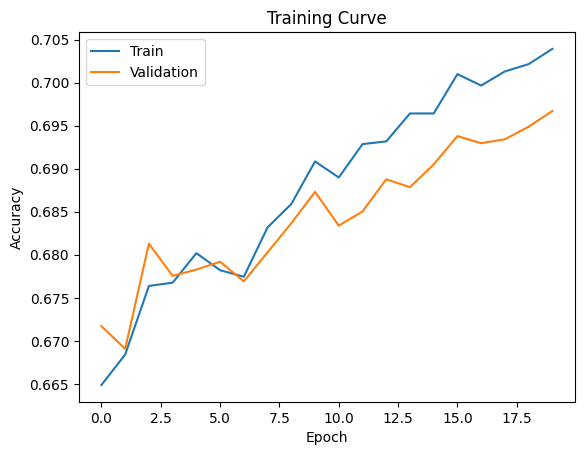

0.7002369668246445

In [36]:
model = TweetRNN(50, 50, 2)
# Train and produce training curve and validation curve
train(model, train_loader, valid_loader, num_epochs=20, learning_rate=2e-4)
# Compute test accuracy
get_accuracy(model, test_loader)

**Model 2:GRU:** Our second model is a GRU with a fully-connected layer applied to the last hidden state, mapping its value into a  2×1  vector (which is converted to a distribution in the computation of the cross entropy loss).

In [37]:
class TweetGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TweetGRU, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Forward propagate the GRU
        out, _ = self.rnn(x)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

Applying the GRU to our data.

Epoch 1; Loss 0.561611; Train Acc 0.705771; Val Acc 0.696972
Epoch 2; Loss 0.463323; Train Acc 0.706338; Val Acc 0.698705
Epoch 3; Loss 0.556111; Train Acc 0.705425; Val Acc 0.697884
Epoch 4; Loss 0.583524; Train Acc 0.706779; Val Acc 0.696517
Epoch 5; Loss 0.571898; Train Acc 0.707126; Val Acc 0.695331
Epoch 6; Loss 0.564596; Train Acc 0.707567; Val Acc 0.698340
Epoch 7; Loss 0.485570; Train Acc 0.707283; Val Acc 0.697976
Epoch 8; Loss 0.456947; Train Acc 0.707661; Val Acc 0.699343
Epoch 9; Loss 0.644465; Train Acc 0.707063; Val Acc 0.697793
Epoch 10; Loss 0.562450; Train Acc 0.707724; Val Acc 0.698523
Epoch 11; Loss 0.445995; Train Acc 0.708071; Val Acc 0.699070
Epoch 12; Loss 0.509723; Train Acc 0.708165; Val Acc 0.696425
Epoch 13; Loss 0.525846; Train Acc 0.708480; Val Acc 0.698340
Epoch 14; Loss 0.622319; Train Acc 0.708701; Val Acc 0.699799
Epoch 15; Loss 0.511589; Train Acc 0.708606; Val Acc 0.697976
Epoch 16; Loss 0.565261; Train Acc 0.707819; Val Acc 0.698340
Epoch 17; Loss 0.

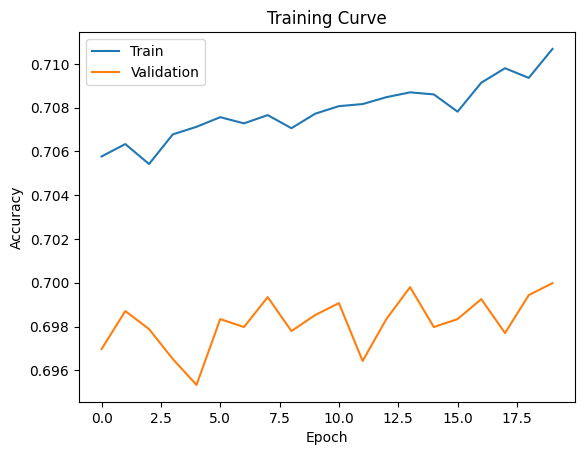

0.7006015311702516

In [38]:
modelGRU = TweetGRU(50, 50, 2)
# Train and produce training curve and validation curve
train(model, train_loader, valid_loader, num_epochs=20, learning_rate=2e-5)
# Compute test accuracy
get_accuracy(model, test_loader)